# EDA
- Updated 2023.04.17
- Written by shyeon

### Preparing to run the code

In [1]:
import os
from pathlib import Path

curr_path = Path().absolute()
os.chdir(curr_path.parent)  # change working directory to parent path

In [2]:
import pickle
from itertools import combinations

import lightgbm as lgb
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from networkx.exception import NetworkXError
from pyvis.network import Network
from sklearn.covariance import GraphicalLassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from src.utils.logger import get_logger


In [3]:
logger = get_logger()
random_seed = 42

### Loading the dataset
- value_df: (156232, 66)

In [4]:
with open("data/processed/values.pickle","rb") as f:
    value_df = pickle.load(f)

print("Data type:", type(value_df))
print("Data size:",value_df.values.shape)
value_df.head()

Data type: <class 'pandas.core.frame.DataFrame'>
Data size: (156232, 66)


,NRn261_TxLOSS_[2077891CH]_TESTPOINT3,NRn261_TxLOSS_[2077891CH]_TESTPOINT2,NRn261_TxLOSS_[2077891CH]_TESTPOINT1,NRn261_TxLOSS_[2077891CH]_TESTPOINT0,NRn260_TxLOSS_[2254147CH]_TESTPOINT3,NRn260_TxLOSS_[2254147CH]_TESTPOINT2,NRn260_TxLOSS_[2254147CH]_TESTPOINT1,NRn260_TxLOSS_[2254147CH]_TESTPOINT0,Battery Level Detect,NRn261[2077891] BEAM16_RX_Estimated Sensitivity-75dBm,...,NRn260[2254147] BEAM31_RX_Estimated Sensitivity-75dBm,NRn260[2254147] BEAM31_Tx_QPSK_POWER,NRn260[2254147] BEAM159_TX_QPSK_ACLR_UPPER,NRn260[2254147] BEAM159_TX_QPSK_FreqError,NRn260[2254147] BEAM159_Tx_QPSK_POWER,NRn260[2254147] BEAM159_TX_QPSK_EVM,NRn260[2254147] BEAM159_RX_Estimated Sensitivity-75dBm,NRn260[2254147] BEAM159_TX_QPSK_ACLR_LOWER,NRn260[2254147] BEAM159_TX_QPSK_IQoffset,RF TEST-TIME
0,-50.21,-43.32,-47.31,-43.43,-49.92,-48.45,-53.03,-50.66,3.83,-97.75,...,-93.89,20.17,-33.93,-2.42,20.39,6.35,-94.92,-35.72,-54.69,12.0
1,-50.20,-43.53,-48.08,-43.70,-51.05,-48.84,-53.61,-50.72,3.86,-99.66,...,-94.95,20.33,-32.68,-1.78,20.60,7.33,-95.56,-34.01,-61.33,12.0
2,-49.79,-44.04,-48.74,-44.28,-51.60,-48.80,-53.75,-50.68,3.87,-100.30,...,-95.43,20.90,-33.31,-0.82,21.21,7.16,-96.74,-34.42,-54.42,12.0
3,-49.91,-45.00,-49.18,-45.34,-52.60,-49.71,-54.86,-51.91,3.89,-99.38,...,-92.71,20.80,-33.52,-2.22,20.90,7.08,-94.19,-35.10,-54.82,12.0
4,-50.11,-44.37,-49.37,-45.00,-52.03,-49.30,-54.69,-52.33,3.88,-98.82,...,-92.81,21.07,-33.27,-2.06,20.01,7.14,-93.17,-34.63,-52.27,12.0


In [5]:
train, test = train_test_split(value_df, test_size=0.5, random_state=random_seed, shuffle=False)
scaler = StandardScaler().fit(train)
scaled_train = pd.DataFrame(scaler.transform(train))
scaled_test = pd.DataFrame(scaler.transform(test))
titles = train.columns.tolist()

### Correlation

In [11]:
corr_df = scaled_train.corr(method="pearson") # 'pearson','spearman', 'kendall'
corr = corr_df.values

<AxesSubplot: >

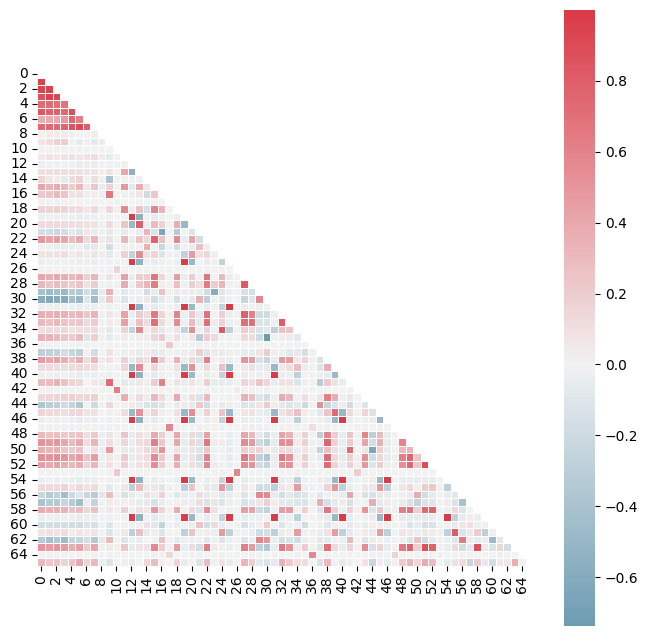

In [12]:
mask = np.triu(np.ones_like(corr, dtype=bool))  # 역 삼각 모양 마스크
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=0.5)

### Graphical Lasso

In [21]:
cov = GraphicalLassoCV().fit(scaled_train.values)
np.around(cov.precision_, decimals=3)

/home/shyeon/.pyenv/versions/3.10.9/envs/graph/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/shyeon/.pyenv/versions/3.10.9/envs/graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -2.395e-04
  warnings.warn(


array([[ 2.311, -0.65 , -0.557, ..., -0.04 , -0.   , -0.   ],
       [-0.65 ,  2.469, -0.559, ..., -0.   , -0.   , -0.   ],
       [-0.557, -0.559,  2.294, ..., -0.031, -0.   , -0.   ],
       ...,
       [-0.04 , -0.   , -0.031, ...,  2.064,  0.   , -0.022],
       [-0.   , -0.   , -0.   , ...,  0.   ,  1.09 ,  0.   ],
       [-0.   , -0.   , -0.   , ..., -0.022,  0.   ,  1.017]])

<AxesSubplot: >

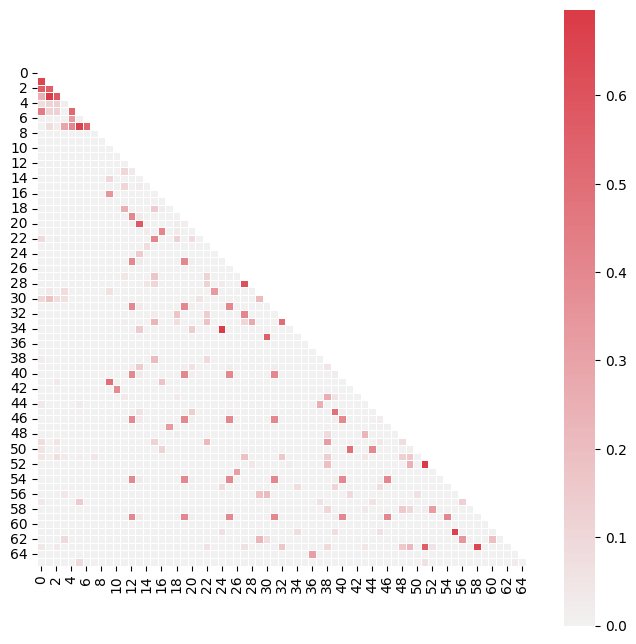

In [23]:
mask = np.triu(np.ones_like(corr, dtype=bool))  # 역 삼각 모양 마스크
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
sns.heatmap(np.abs(cov.precision_), mask=mask, cmap=cmap, center=0, square=True, linewidths=0.5)